In [58]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from pathlib import Path

import config

In [2]:
img_path = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"

In [3]:
img = cv2.imread(str(img_path))

In [4]:
def thresholding(image, th=80, imshow=False):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,th,255,cv2.THRESH_BINARY_INV)
    if imshow: plt.imshow(thresh, cmap='gray'); plt.show()
    return thresh

In [5]:
def dilation(thresh_img, imshow=False):
    kernel = np.ones((3,85), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
    if imshow: plt.imshow(dilated, cmap='gray'); plt.show()
    return dilated

In [6]:
def find_contours(dialted_img):
    (contours, heirarchy) = cv2.findContours(dialted_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)
    return sorted_contours_lines

In [7]:
def get_line_contours(img, imshow=False):
    """Returns text lines."""
    thresh_img = thresholding(img, imshow=imshow)
    dilated_img = dilation(thresh_img, imshow=imshow)
    sorted_contours_lines = find_contours(dilated_img)

    # filter out one text lines
    if imshow: img2 = img.copy()
    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        if h < 30: continue
        if imshow: cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
        yield x, y, w, h
        
    if imshow: plt.imshow(img2); plt.show()

In [9]:
line_contours = list(get_line_contours(img, imshow=False))

In [10]:
def get_lines(img):
    for x, y, w, h in get_line_contours(img):
        yield img[y:y+h, x:x+w].copy()

In [11]:
lines = list(get_lines(img))

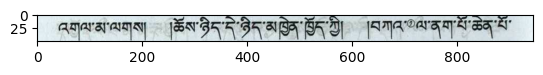

In [12]:
plt.imshow(lines[3])
plt.show()

In [13]:
def create_template(image_fn, template_name, n_line, x, w):
    img = cv2.imread(str(image_fn))
    lines = list(get_lines(img))
    line = lines[n_line-1]
    plt.imshow(line)
    plt.show()
    template = line[0:line.shape[0], x:x+w]
    plt.imshow(template)
    plt.show()

    template_fn = config.TEMPLATES_PATH / f"{template_name}.png"
    cv2.imwrite(str(template_fn), template)

In [14]:
# image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"
# create_template(image_fn, "01", 4, 705, 16)
# create_template(image_fn, "02", 7, 571, 17)
# create_template(image_fn, "03", 13, 68, 16)
# create_template(image_fn, "04", 15, 836, 16)
# create_template(image_fn, "05", 17, 461, 16)
# create_template(image_fn, "06", 20, 602, 17)
# create_template(image_fn, "07", 21, 763, 16)

In [113]:
def match_template(img, template, th=0.85, imshow=False):
    """find the given template on the image

    Returns:
        - loc ([(x, y), ...]: list of matched template (x,y)
    """
    img_copy = img.copy()
    h, w, _ = template.shape
    
    res = cv2.matchTemplate(img_copy, template, cv2.TM_CCOEFF_NORMED)
    
    loc = np.where(res >= th)
    
    if imshow:
        # Draw rectangles around matched regions
        for pt in zip(*loc[::-1]):
            cv2.rectangle(img_copy, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
        if loc:
            plt.imshow(img_copy)
            plt.show()
    return zip(*loc[::-1])

In [114]:
def find_pedurma_note_number(image, th=0.85, imshow=False):

    def find_unique_matches(matches):
        matches.sort(key=lambda x: x[0])
        grouped_matches = []
        similar_matches = [matches[0]]
        prev_match = matches[0]
        for match in matches[1:]:
            if abs(match[0]-prev_match[0]) > 10 and abs(match[1]-prev_match[1]) > 10:
                grouped_matches.append(similar_matches)
                similar_matches = []
            similar_matches.append(match)
            prev_match = match

        if similar_matches:
            grouped_matches.append(similar_matches)

        unique_matches = []
        for matches in grouped_matches:
            unique_matches.append(matches[0])

        return unique_matches

    if isinstance(image, (Path, str)):            
        img = cv2.imread(str(image_fn))
    else:
        img = image.copy()
        
    all_matches = []
    for template_fn in sorted(config.TEMPLATES_PATH.iterdir()):
        if not template_fn.name.endswith(".png"): continue
        template = cv2.imread(str(template_fn))
        matches = match_template(img, template, th=th)
        all_matches.extend(matches)

    unique_matches = find_unique_matches(all_matches)

    if imshow:
        h, w, _ = template.shape
        for x, y in unique_matches:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        plt.imshow(img)
        plt.show()
        
    return unique_matches

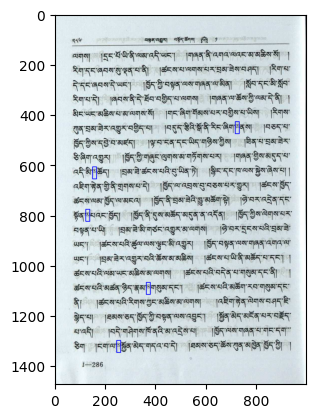

5

In [115]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460324.jpg"
matches = find_pedurma_note_number(image_fn, imshow=True)
len(matches)

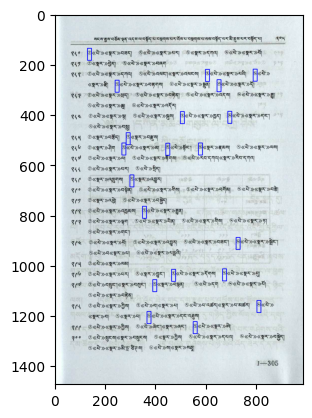

20

In [116]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460343.jpg"
matches = find_pedurma_note_number(image_fn, th=0.8, imshow=True)
len(matches)

In [120]:
def insert_text(image, text, position):
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    color = (0, 0, 0) # Blue in BGR
    thickness = 2
    line_type = cv2.LINE_AA
    cv2.putText(image, text, position, font, font_scale, color, thickness, line_type)
    return image

def remove_old_maker(image, position):
    x, y = position
    h, w = 50, 16
    patch = image[0:h, 0:w]
    image[y:y+h, x:x+w] = patch
    return image

def alter_note_maker(image_fn, insert_char=None, output_name="output"):
    image = cv2.imread(str(image_fn))
    matches = find_pedurma_note_number(image, imshow=True)
    
    for x, y in matches:
        image = remove_old_maker(image, (x, y))
        if insert_char:
            insert_text(image, insert_char, (x, y+20))
            output_fn = f"{output_name}_{insert_char}.png"
        else:
            # insert black circle covering the note maker
            cv2.circle(image, (x+7, y+15), 10, (0,0,0), -1)
            output_fn = f"{output_name}_circle.png"
            
    cv2.imwrite(output_fn, image)
    plt.imshow(image)
    plt.show()

    return image

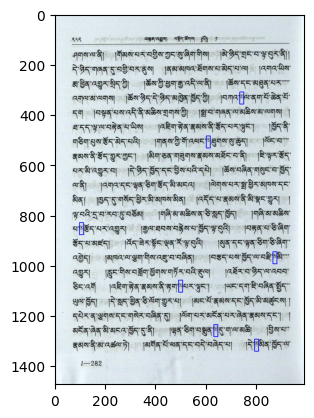

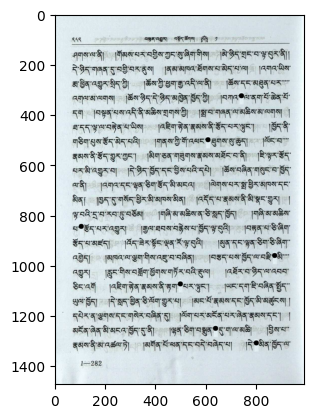

In [121]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"
image_new_note_maker = alter_note_maker(image_fn)

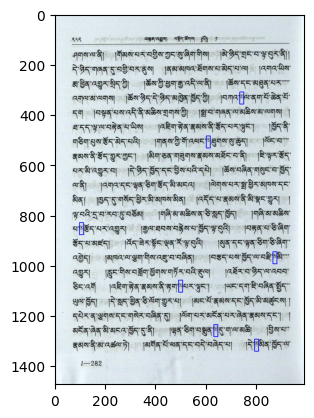

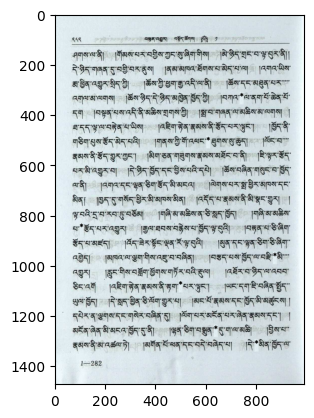

In [126]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460320.jpg"
image_new_note_maker = alter_note_maker(image_fn, "*", "I1PD958460320")

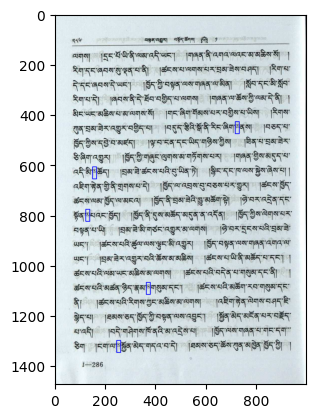

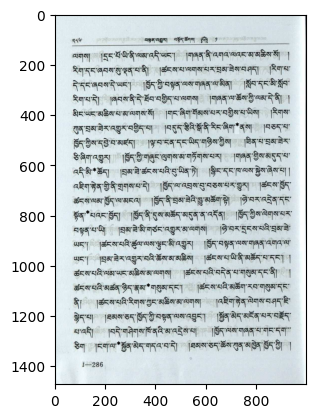

In [127]:
image_fn = config.IMAGES_PATH / "W1PD95844" / "W1PD95844-I1PD95846" / "images" / "I1PD958460324.jpg"
image_new_note_maker = alter_note_maker(image_fn, "*", "I1PD958460324")